In [4]:
import zipfile
zip_file_path = "/content/archive (12).zip"
extract_path = "./dataset"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2


In [6]:
import os

# Define the path where the dataset is extracted
extract_path = "./dataset"  # Change this if the extraction path is different

# Find the extracted CSV file
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

if csv_files:
    csv_filename = csv_files[0]  # Get the first CSV file
    csv_path = os.path.join(extract_path, csv_filename)  # Full path to CSV
    print(f"Found CSV file: {csv_filename}")
else:
    print("No CSV file found in the directory.")


Found CSV file: synthetic_indian_upi_fraud_data.csv


In [7]:

df = pd.read_csv(csv_path)

# Display first 5 rows
print(df.head())

   TransactionID                                UserID   Amount  \
0   842835309389  b0b99baa-1fd2-41e5-ac94-37aa0ec862f9  8589.00   
1   592863054785  0cc467c5-8b71-4ba4-9c75-4a9e2bec2c8c  9090.54   
2   373481869464  f7de03ee-b7f5-4568-8ba2-e889bced4d88  8814.41   
3   285572156436  456b3f39-e9cc-429f-8568-125612c12987  3971.25   
4   874207772966  7b4b734d-f0c5-4dce-8b9c-0b2e226abc86  4376.74   

             Timestamp MerchantCategory TransactionType  \
0  2024-01-22 03:59:58      Electronics             P2M   
1  2024-07-01 13:43:33      Electronics             P2M   
2  2024-04-02 05:23:39      Electronics             P2P   
3  2024-06-14 16:13:43      Restaurants             P2P   
4  2024-07-16 03:22:40        Groceries             P2M   

                               DeviceID        IPAddress   Latitude  \
0  42296fa1-8d7a-478c-a8c9-590b9d14cdb9    75.122.84.213  23.354478   
1  e566b8a8-17c3-4372-9e07-e4c4eb3113b7     16.110.81.53 -62.956912   
2  897d0824-bc4f-4ee7-9bfb-c8

In [8]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [9]:
df = pd.get_dummies(df, drop_first=True)

In [10]:
X = df.drop(columns=['FraudFlag'])  # Replace with actual target column name
y = df['FraudFlag']


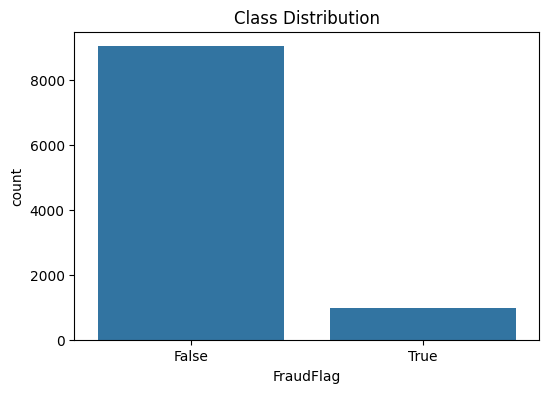

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()


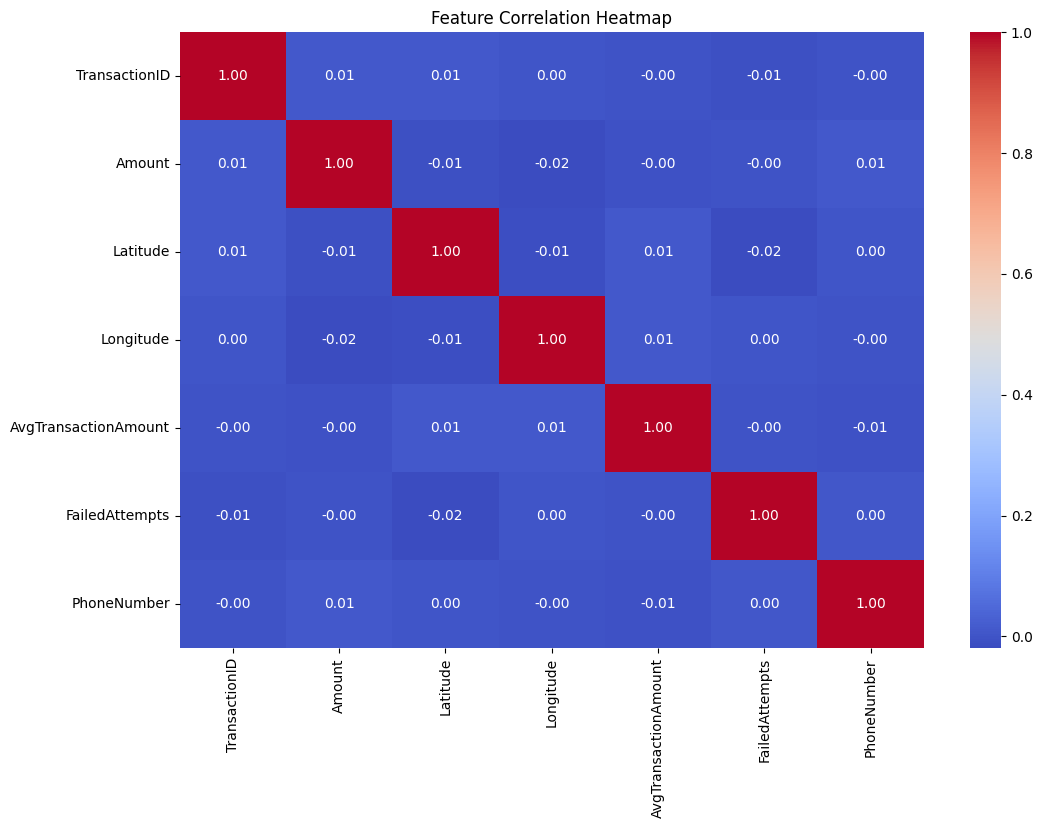

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_numeric = df.select_dtypes(include=['number'])  


if df_numeric.shape[1] == 0:
    print("No numeric columns available for correlation heatmap.")
else:
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['FraudFlag'])
y = df['FraudFlag']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


print(pd.Series(y_train_resampled).value_counts())

FraudFlag
False    7228
True     3614
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

# Split dataset (Train-Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.5, random_state=42)


rf_params = {
    "n_estimators": [50, 100], 
    "max_depth": [10, 20, None],
    "min_samples_split": [5, 10]  
}


rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10, 
    cv=3,
    scoring="roc_auc",
    verbose=1,
    n_jobs=2  
)


rf.fit(X_train_small, y_train_small)


best_rf = rf.best_estimator_


y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability of fraud


print("Best parameters:", rf.best_params_)


auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")


print("Prediction Probabilities (first 5):", y_pred_proba[:5])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': None}
ROC AUC Score: 0.5082
Prediction Probabilities (first 5): [0.00607576 0.00636544 0.00986555 0.00833333 0.01784149]


In [ ]:
import numpy as np
import pandas as pd
import gc  
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)


gc.collect()

xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
}


xgb = RandomizedSearchCV(
    XGBClassifier(eval_metric="logloss", tree_method="hist"),  
    param_distributions=xgb_params,
    n_iter=2,  
    cv=2,  
    scoring="roc_auc",
    verbose=1,
    n_jobs=1  
)

xgb.fit(X_train_small, y_train_small)


best_xgb = xgb.best_estimator_


y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  


print("Best parameters:", xgb.best_params_)


auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")


print("Prediction Probabilities (first 5):", y_pred_proba[:5])


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
ROC AUC Score: 0.4916
Prediction Probabilities (first 5): [0.02935918 0.0175855  0.02386286 0.20619167 0.18367238]


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


models = {"Random Forest": best_rf, "XGBoost": best_xgb}


for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  

    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")



Random Forest Performance:
Accuracy: 0.9035
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.5082


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



XGBoost Performance:
Accuracy: 0.9040
Precision: 1.0000
Recall: 0.0052
F1 Score: 0.0103
AUC-ROC: 0.4916


In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler  # Import scaler if used


scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)  


joblib.dump(best_rf, "upi_fraud_rf_model.pkl")
joblib.dump(best_xgb, "upi_fraud_xgb_model.pkl")


if "scaler" in globals():
    joblib.dump(scaler, "upi_scaler.pkl")
    print("Scaler saved successfully!")

print("Models saved successfully!")


Scaler saved successfully!
Models saved successfully!
